# Modeling Notebook + preprocessing so data is ready for Modeling

In [1]:
#Importing necessary packages and libraries
import twint
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeffreyng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jeffreyng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jeffreyng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
#importing more necessary packages
from nltk.tokenize import RegexpTokenizer
import re

In [3]:
#scraped CSV into dataframe
df=pd.read_csv('Jeff.csv')
df.shape

(7137, 35)

In [6]:
#importing the vader sentiment analysis package and instantiating it
data=df
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [7]:
#wrote a function to get the vader scores fir my data
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)

In [8]:
#list comprehension using my written function
a= [analyser.polarity_scores(x) for x in data['tweet']]

In [9]:
#pulling the relevant score into a list 
b= [x.items() for x in a]

In [10]:
#creating a dataframe of my vader scores of the tweets
data1=pd.DataFrame(b, columns= ['neg', 'neu', 'pos', 'comp'])

In [11]:
b = data1['comp']

In [12]:
#making a column that grabs the right compound score to gauge sentiment
data1['comp2']= [score[1] for score in b]

In [13]:
k=data1['comp2']

In [14]:
#rounding out my vader score
data1['comp2']= data1['comp2'].round(3)

In [15]:
#converting the vader scores into something easier to manipulate so that I can generate 
#three distinct classes
col         = 'comp2'
conditions  = [ data1[col] >= .05, (data1[col] < .05) & (data1[col]> -.05), data1[col] <= -.05 ]
choices     = [ 1, 0, -1 ]
data1["comp3"] = np.select(conditions, choices, default=np.nan)

In [16]:
#final conversion step of the data to equate vader score with the three class of sentiments
data1['comp4']= data1['comp3'].map({-1:'negative', 0: 'neutral', 1:'positive'})

In [17]:
#concating dataframe of useful items for NLP analysis
main_data= pd.concat([data['tweet'], data['language'], data1['comp4']], axis=1, join='outer')

In [18]:
#grabbing only the tweets in English
Work_data= main_data[main_data['language']=='en']

In [74]:
#defining my X variable as well as my target(y)
X= Work_data['tweet']
y= Work_data['comp4']

In [75]:
#train_test_split
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=.20, random_state=23)

In [60]:
#created a NLP processing function that includes all the steps of corpus cleaning and creation
def NLP_process(data):
    BoW=[]
    for word in data:
        BoW.append(word)
    word_bank= ' '.join(BoW)
    word_bank= word_bank.lower()
#     from nltk.tokenize import RegexpTokenizer
    tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    tokenized_tweets= tokenizer.tokenize(word_bank)
#     import string
    sw_list = stopwords.words('english')
    sw_list += list(string.punctuation)
    sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©', '#', '@', 
            'said', 'one', 'com', '-', '–', '—']
    sw_list += ['www', 'the', 'to', 'and', 'a', 's', 't','is', 'you', 'of', 'i', 
            'in', 'this', 'are', 'it', 'for', 'https', 'com', 'twitter', 'alllivesmatter' , 
            'blacklivesmatter' , 'bluelivesmatter']
    sw_set = set(sw_list)
    filtered_tweets=[]
    for word in tokenized_tweets:
        if word not in sw_set:
            filtered_tweets.append(word)
#     from nltk.stem import WordNetLemmatizer 
    lemmatizer=WordNetLemmatizer()
    X_lemmatized_tweets=[]
    for w in filtered_tweets:
        X_lemmatized_tweets.append(lemmatizer.lemmatize(w))
    return (X_lemmatized_tweets)
    

In [61]:
#using the NLP processing function on data
NLP_process(X_test)

['bet',
 'as',
 'woman',
 'animal',
 'would',
 'broken',
 'jaw',
 'tried',
 'shit',
 'partner',
 'butblacklivesmatter',
 'mcox',
 'status',
 'miss',
 'swimsuit',
 'uk',
 'stripped',
 'title',
 'posting',
 'life',
 'matter',
 'facebook',
 'questioning',
 'george',
 'floyd',
 'innocent',
 'thegatewaypundit',
 'miss',
 'swimsuit',
 'uk',
 'stripped',
 'title',
 'posting',
 'life',
 'matter',
 'facebook',
 'questioning',
 'george',
 'floyd',
 'innocent',
 'utm',
 'source',
 'utm',
 'medium',
 'posttopsharingbuttons',
 'utm',
 'campaign',
 'websitesharingbuttons',
 'via',
 'gatewaypundit',
 'fascist',
 'racist',
 'society',
 'racist',
 'say',
 'racist',
 'say',
 'white',
 'people',
 'really',
 'read',
 'praying',
 'pregnant',
 'woman',
 'safe',
 'delivery',
 'notjustblacklives',
 'alllives',
 'chefmade',
 'status',
 'fact',
 'fact',
 'black',
 'biggest',
 'threat',
 'black',
 'life',
 'country',
 'even',
 'close',
 'sickening',
 'going',
 'black',
 'neighborhood',
 'brave',
 'strong',
 'peo

In [22]:
#creating word bank from tweets
BoW=[]
for word in X_train:
    BoW.append(word)
len(BoW)

3904

In [23]:
#creating corpus, lowercasing the words, stripping of whitespace
word_bank= ' '.join(BoW)
word_bank= word_bank.lower()
word_bank

'i’ll fund their defense!! #alllivesmatter #trump2020landslidevictory all lives matter and if dems ever get in charge better get guns! @realdonaldtrump @potus @presssec @whitehouse @alm @bluelivesmtr @blm @thereval @foxnews @abcnews @nbcnews @gop @thedemocrats @speakerpelosi @senschumer #bluelivesmatter #alllivesmatter @joebiden https://twitter.com/realdonaldtrump/status/1284162207232733185\xa0… yes... means equality regardless of color, race, religion, sexual preference etc.. no? we are all human and bleed the same color. #alllivesmatter 💙❤🖤 what do you expect..these numptys are all lemmings..if one jumps off the cliff they\'d all follow..there all devoid of brains..#alllivesmatter this idiot has no clue about the law the doctor she is must be dr. of colored on eyebrows.\nshe\'s a white woman of color lmao... and i\'m an attack helicopter 🚁...\nanother person not capable of thinking logically when the word trump is involved.\n#alllivesmatter no order for the police to stand down for t

In [24]:
#manually tokenizing the corpus
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
tokenized_tweets= tokenizer.tokenize(word_bank)

In [25]:
tokenized_tweets

['i',
 'll',
 'fund',
 'their',
 'defense',
 'alllivesmatter',
 'trump',
 'landslidevictory',
 'all',
 'lives',
 'matter',
 'and',
 'if',
 'dems',
 'ever',
 'get',
 'in',
 'charge',
 'better',
 'get',
 'guns',
 'realdonaldtrump',
 'potus',
 'presssec',
 'whitehouse',
 'alm',
 'bluelivesmtr',
 'blm',
 'thereval',
 'foxnews',
 'abcnews',
 'nbcnews',
 'gop',
 'thedemocrats',
 'speakerpelosi',
 'senschumer',
 'bluelivesmatter',
 'alllivesmatter',
 'joebiden',
 'https',
 'twitter',
 'com',
 'realdonaldtrump',
 'status',
 'yes',
 'means',
 'equality',
 'regardless',
 'of',
 'color',
 'race',
 'religion',
 'sexual',
 'preference',
 'etc',
 'no',
 'we',
 'are',
 'all',
 'human',
 'and',
 'bleed',
 'the',
 'same',
 'color',
 'alllivesmatter',
 'what',
 'do',
 'you',
 'expect',
 'these',
 'numptys',
 'are',
 'all',
 'lemmings',
 'if',
 'one',
 'jumps',
 'off',
 'the',
 'cliff',
 'they',
 'd',
 'all',
 'follow',
 'there',
 'all',
 'devoid',
 'of',
 'brains',
 'alllivesmatter',
 'this',
 'idiot',


In [26]:
#creating stop words to filter our word bank
import string
sw_list = stopwords.words('english')
sw_list += list(string.punctuation)
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©', '#', '@', 
            'said', 'one', 'com', '-', '–', '—']
sw_list += ['www', 'the', 'to', 'and', 'a', 's', 't','is', 'you', 'of', 'i', 
            'in', 'this', 'are', 'it', 'for', 'https', 'com', 'twitter', 'alllivesmatter' , 
            'blacklivesmatter' , 'bluelivesmatter']
sw_set = set(sw_list)

In [27]:
#list of stopwords and punctuation
print(sw_set)

{'%', 'or', 'ourselves', 'those', 'but', 'about', "she's", 'can', 'who', 'is', 'she', 'under', 'after', "wasn't", 'into', 'once', 'at', 'y', 'just', '~', '>', "couldn't", "you'd", 'any', 'mustn', '.', '"', 've', 'didn', 'which', "hadn't", '”', '‘', '©', "isn't", 'com', 'here', 'for', ';', ')', '$', '""', "it's", 'my', 'his', 'if', 'https', 'won', 'blacklivesmatter', 'same', 'themselves', 'whom', "you're", 'you', "you'll", 'that', '|', 'our', 'why', 'down', "shouldn't", '“', 'do', 'twitter', 'of', '=', 'yours', 'to', 'wasn', 'theirs', 'being', 'should', 'both', 'herself', 'weren', "needn't", 'own', "didn't", ',', '+', 'through', 'needn', 'bluelivesmatter', '/', 'during', 'its', 'couldn', 'haven', 'when', 'it', '’', 'again', 'nor', 'ours', '!', 'myself', 'as', 'more', 'above', 'll', '}', 'he', 'further', 'hasn', 'and', 'have', 'yourselves', '...', 'them', "haven't", 'the', 'now', 'we', 'their', 'hers', 'isn', 'alllivesmatter', 's', 'where', 'hadn', 'itself', 'each', 'me', 'most', '(', '*

In [28]:
#filtering out stopwords
filtered_tweets=[]
for word in tokenized_tweets:
    if word not in sw_set:
        filtered_tweets.append(word)

In [30]:
#lemmatizing
from nltk.stem import WordNetLemmatizer 
lemmatizer=WordNetLemmatizer()
X_lemmatized_tweets=[]
for w in filtered_tweets:
    X_lemmatized_tweets.append(lemmatizer.lemmatize(w))
print (X_lemmatized_tweets)

['fund', 'defense', 'trump', 'landslidevictory', 'life', 'matter', 'dems', 'ever', 'get', 'charge', 'better', 'get', 'gun', 'realdonaldtrump', 'potus', 'presssec', 'whitehouse', 'alm', 'bluelivesmtr', 'blm', 'thereval', 'foxnews', 'abcnews', 'nbcnews', 'gop', 'thedemocrats', 'speakerpelosi', 'senschumer', 'joebiden', 'realdonaldtrump', 'status', 'yes', 'mean', 'equality', 'regardless', 'color', 'race', 'religion', 'sexual', 'preference', 'etc', 'human', 'bleed', 'color', 'expect', 'numptys', 'lemming', 'jump', 'cliff', 'follow', 'devoid', 'brain', 'idiot', 'clue', 'law', 'doctor', 'must', 'dr', 'colored', 'eyebrow', 'white', 'woman', 'color', 'lmao', 'attack', 'helicopter', 'another', 'person', 'capable', 'thinking', 'logically', 'word', 'trump', 'involved', 'order', 'police', 'stand', 'ridiculous', 'mural', 'stand', 'throwing', 'blue', 'paint', 'police', 'arrest', 'arrest', 'billdeblasio', 'traitor', 'evil', 'tyranny', 'cannot', 'go', 'unpunished', 'barack', 'hussein', 'obama', 'hilla

In [77]:
#using function to process my data
X_train_processed= NLP_process(X_train)

In [69]:
#using function to process data
X_test_processed=NLP_process(X_test)

In [70]:
#using function to process data
y_train_processed= NLP_process(y_train)

In [246]:
#using tf_idf vectorizer
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2), lowercase=True)
tfidf_data_train_lem = tfidf.fit_transform(X_train)
tfidf_data_test_lem = tfidf.transform(X_test)

tfidf_data_train_lem
dfq = pd.DataFrame(tfidf_data_train_lem.toarray().transpose(),
                 index = tfidf.get_feature_names())

In [247]:
dfq

,0,1,2,3,4,5,6,7,8,9,...,3894,3895,3896,3897,3898,3899,3900,3901,3902,3903
000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000 federal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000 help,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000 hours,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000 years,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
اعدام_نکنید stopexecutionsiniran,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
سرايا_السلام,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
سرايا_السلام pic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
태민아_짝궁들이_생일축하한대,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [241]:
#initializing RandomForest 
rfc = RandomForestClassifier(n_estimators=200, criterion='entropy',random_state=0, n_jobs=-1)

In [242]:
#fitting model
rfc.fit(tfidf_data_train_lem, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=200, n_jobs=-1,
                       random_state=0)

In [243]:
#predicting model
rfc_preds= rfc.predict(tfidf_data_test_lem)

In [244]:
#printing out evaluation metrics
print(metrics.accuracy_score(y_test, rfc_preds))
print(metrics.precision_score(y_test, rfc_preds, average='weighted'))
print(metrics.recall_score(y_test, rfc_preds, average='weighted'))
print(metrics.f1_score(y_test, rfc_preds, average='weighted'))



0.8884339815762539
0.8964467701983134
0.8884339815762539
0.8903577578123266


In [123]:
#a look of the counts of predictions
pd.Series(rfc_preds).value_counts()


negative    488
positive    335
neutral     154
dtype: int64

In [124]:
#a comparison of the counts of prediction and actual 
pd.Series(y_test).value_counts()

negative    453
positive    366
neutral     158
Name: comp4, dtype: int64

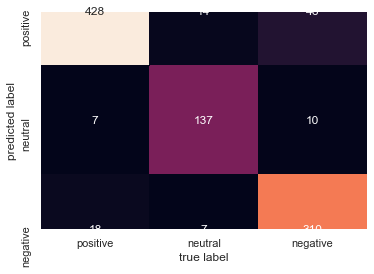

In [116]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()


mat = confusion_matrix(y_test, rfc_preds)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [228]:
#Naive Bayes Classifier 
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=.001, fit_prior=False)

In [229]:
#fitting model with tf_idf vectorized data
clf.fit(tfidf_data_train_lem, y_train)

MultinomialNB(alpha=0.001, fit_prior=False)

In [230]:
#predicting model
clf_preds= clf.predict(tfidf_data_test_lem)

In [231]:
#evaluation metrics
print(metrics.accuracy_score(y_test, clf_preds))
print(metrics.precision_score(y_test, clf_preds, average='weighted'))
print(metrics.recall_score(y_test, clf_preds, average='weighted'))
print(metrics.f1_score(y_test, clf_preds, average='weighted'))

0.8935516888433982
0.8941648852890433
0.8935516888433982
0.8932431025241255


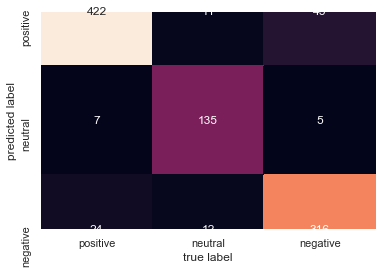

In [232]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()


mat = confusion_matrix(y_test, clf_preds)
sns.heatmap(mat.T, square=False, annot=True, fmt='d', cbar=False,
            xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [142]:
#starting SVM model
from sklearn import svm

In [188]:
#setting hyperparameters for the SVM model
svm_clf = svm.SVC(kernel='rbf', C=10)

In [189]:
#fitting the SVM model
svm_clf.fit(tfidf_data_train_lem, y_train)

SVC(C=10)

In [190]:
#predicting the classification with SVM
svm_preds=svm_clf.predict(tfidf_data_test_lem)

In [191]:
#Evaluation metrics
print(metrics.accuracy_score(y_test, svm_preds))
print(metrics.precision_score(y_test, svm_preds, average='weighted'))
print(metrics.recall_score(y_test, svm_preds, average='weighted'))
print(metrics.f1_score(y_test, svm_preds, average='weighted'))

0.9058341862845445
0.9077273042408137
0.9058341862845445
0.9054938244664402
